<a href="https://colab.research.google.com/github/rylan-berry/DeepLearningIndependentStudy/blob/main/RegularizationLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Making Regularization Algorithms from Scratch

##Data Download

In [1]:
!git clone "https://github.com/rylan-berry/DeepLearningIndependentStudy.git"

Cloning into 'DeepLearningIndependentStudy'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 48 (delta 15), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 1.62 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Filtering content: 100% (2/2), 121.94 MiB | 29.27 MiB/s, done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv("DeepLearningIndependentStudy/mnist_train.csv", header=None)
y_train = train_data[0].to_numpy()
x_train = train_data.drop(0, axis=1).to_numpy() / 255.0 #converts the inputs from 0-255 to 0-1, normalizing inputs

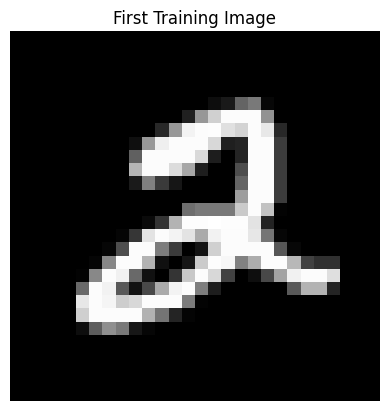

In [4]:
#sample input
#plotting done by gemini
image_data = x_train[5].reshape(28, 28) # Reshape to 28x28 for display
plt.imshow(image_data, cmap='gray') # Display the image in grayscale
plt.title("First Training Image")
plt.axis('off') # Hide axes
plt.show()

In [5]:
val_data = pd.read_csv("DeepLearningIndependentStudy/mnist_test.csv", header=None)
y_val = val_data[0].to_numpy()
x_val = val_data.drop(0, axis=1).to_numpy()/255.0 #converts the inputs from 0-255 to 0-1, normalizing inputs

In [6]:
# Code produced by gemini
# Define the number of classes (0-9 for MNIST)
num_classes = 10

# Convert y_train to one-hot encoding
y_train = np.eye(num_classes)[y_train.astype(int)]

# Convert y_val to one-hot encoding
y_val = np.eye(num_classes)[y_val.astype(int)]

print("y_train after one-hot encoding (first 5 samples):")
print(y_train[:5])
print("\ny_val after one-hot encoding (first 5 samples):")
print(y_val[:5])


y_train after one-hot encoding (first 5 samples):
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

y_val after one-hot encoding (first 5 samples):
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [7]:
y_train.shape, x_train.shape

((60000, 10), (60000, 784))

##Sub Model Structuring

###Auto Gradient

In [8]:
class Values:
  def __init__(self, vals, grads = True):
    self.vals = np.array(vals)
    self._backward = lambda: None
    self.grad = np.zeros_like(vals)
    self.grad_flag = grads

  #Gemini code that handles wierd broadcasting errors
  @staticmethod
  def _broadcast_grad(grad_from_output, original_shape):
    """
    Adjusts the gradient by summing over broadcasted dimensions to match the original shape.
    Assumes `grad_from_output` has the shape of the broadcasted result.
    `original_shape` is the shape of the tensor *before* broadcasting.
    """

    if grad_from_output.shape == original_shape:
        return grad_from_output

    # If original was a scalar, sum all dimensions of the gradient
    if original_shape == (): # scalar
        return np.sum(grad_from_output)

    # Identify axes where original_shape has size 1 and grad_from_output has size > 1
    axes_to_sum = []

    # Handle cases where original_shape might have fewer dimensions than grad_from_output
    # e.g., (D,) broadcast to (N, D). original_shape is padded implicitly with 1s on the left.
    diff_ndim = grad_from_output.ndim - len(original_shape)
    padded_original_shape = (1,) * diff_ndim + original_shape

    for i in range(grad_from_output.ndim):
        if padded_original_shape[i] == 1 and grad_from_output.shape[i] > 1:
            axes_to_sum.append(i)

    if axes_to_sum:
        return np.sum(grad_from_output, axis=tuple(axes_to_sum), keepdims=True)

    return grad_from_output # No broadcasting to sum over, or complex broadcasting not handled by this simple logic.

  def __repr__(self):
    return "vals: " + self.vals.__repr__() + "\ngrads: "+ self.grad.__repr__()

  def __add__(self, other):
    other = other if isinstance(other, Values) else Values(other)

    out = Values(self.vals + other.vals)
    def backward():
      if self.grad_flag:
        self_grad_to_add = Values._broadcast_grad(out.grad, self.vals.shape)
        self.grad = self.grad + self_grad_to_add
        self._backward()
      if other.grad_flag:
        other_grad_to_add = Values._broadcast_grad(out.grad, other.vals.shape)
        other.grad = other.grad + other_grad_to_add
        other._backward()

    out._backward = backward
    return out
  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return other + (-self)

  def __mul__(self, other):
    other = other if isinstance(other, Values) else Values(other)

    out = Values(self.vals * other.vals)
    def backward():
      if self.grad_flag:
        # Gradient for self is `other.vals * out.grad`
        grad_term_for_self = other.vals * out.grad
        self.grad =self.grad + Values._broadcast_grad(grad_term_for_self, self.vals.shape)
      if other.grad_flag:
        # Gradient for other is `self.vals * out.grad`
        grad_term_for_other = self.vals * out.grad
        other.grad =other.grad + Values._broadcast_grad(grad_term_for_other, other.vals.shape)
        other._backward()
      if self.grad_flag:
        self._backward()

    out._backward = backward
    return out

  def __rmul__(self, other): #other * self
    return self * other

  def __truediv__(self, other):
    other = other if isinstance(other, Values) else Values(other)

    out = Values(self.vals / other.vals)
    def backward():
      if self.grad_flag:
        grad_term_for_self = out.grad / other.vals
        self.grad = self.grad + Values._broadcast_grad(grad_term_for_self, self.vals.shape)
      if other.grad_flag:
        grad_term_for_other = -out.grad * self.vals / (other.vals**2)
        other.grad = other.grad + Values._broadcast_grad(grad_term_for_other, other.vals.shape)
        other._backward()
      if self.grad_flag:
        self._backward()
    out._backward = backward
    return out

  def __rtruediv__(self, other):
    return Values(other) / self

  def __matmul__(self, other):
    other = other if isinstance(other, Values) else Values(other)
    out = Values(self.vals @ other.vals)
    def backward():
      if self.grad_flag:
        # out.grad @ other.vals.T matches self.vals shape, so no broadcast_grad needed here.
        self.grad = self.grad + out.grad @ other.vals.T
      if other.grad_flag:
        # self.vals.T @ out.grad matches other.vals shape, so no broadcast_grad needed here.
        other.grad = other.grad + self.vals.T @ out.grad
        other._backward()
      if self.grad_flag:
        self._backward()
    out._backward = backward
    return out

  def __rmatmul__(self, other):
    return Values(other) @ self

  def exp(self):
    out = Values(np.exp(self.vals))
    def backward():
      if self.grad_flag:
        grad_term = out.vals * out.grad
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Values(self.vals**other)
    def backward():
      if self.grad_flag:
        grad_term = other * (self.vals**(other - 1)) * out.grad
        self.grad =self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def log(self):
    out = Values(np.log(self.vals))
    def backward():
      if self.grad_flag:
        grad_term = self.vals**-1 *out.grad
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def relu(self):
    out = Values(np.maximum(0,self.vals))
    def backward():
      if self.grad_flag:
        grad_term = out.grad * (self.vals > 0)
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def abs(self):
    out = Values(np.abs(self.vals))
    def backward():
      if self.grad_flag:
        # Gradient of abs(x) is np.sign(x)
        grad_term = out.grad * np.sign(self.vals)
        self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
        self._backward()
    out._backward = backward
    return out

  def sum(self, axis=None, keepdims=False):
    out_vals = np.sum(self.vals, axis=axis, keepdims=keepdims)
    out = Values(out_vals)
    saved_axis = axis
    saved_keepdims = keepdims
    original_shape = self.vals.shape

    def backward():
        if self.grad_flag:
            grad_to_distribute = out.grad

            if saved_axis is not None and not saved_keepdims:
                new_shape = list(original_shape)
                if isinstance(saved_axis, int):
                    new_shape[saved_axis] = 1
                else:
                    for ax in saved_axis:
                        new_shape[ax] = 1
                grad_to_distribute = grad_to_distribute.reshape(new_shape)

            self.grad = self.grad + Values._broadcast_grad(grad_to_distribute, self.vals.shape)
            self._backward()
    out._backward = backward
    return out

  def softmax(self, axis=-1):
    max_val = self.vals.max(axis=axis, keepdims=True)
    exp_vals = (self - max_val).exp()
    sum_exp_vals = exp_vals.sum(axis=axis, keepdims=True)
    out = Values(exp_vals / sum_exp_vals)

    def backward():
        if self.grad_flag:
            sum_grad_times_out = (out.vals * out.grad).sum(axis=axis, keepdims=True)
            grad_term = out.vals * (out.grad - sum_grad_times_out)
            self.grad = self.grad + Values._broadcast_grad(grad_term, self.vals.shape)
            self._backward()
    out._backward = backward
    return out

  def mean(self):
    out = Values(np.mean(self.vals))
    def backward():
      if self.grad_flag:
        # For mean, out.grad is a scalar. Adding a scalar to self.grad (an array)
        # implicitly broadcasts the scalar across all elements, which is the correct behavior
        # for the gradient of a mean operation.
        self.grad = self.grad + (out.grad / self.vals.size)
        self._backward()
    out._backward = backward
    return out

  def __call__(self):
    return self

  def __getitem__(self, item):
    out = Values(self.vals[item])
    saved_item = item
    def backward():
        if self.grad_flag:
            temp_grad = np.zeros_like(self.vals)
            temp_grad[saved_item] = out.grad
            self._backward()
    out._backward = backward
    return out

  def backward(self):
    self.grad = np.ones_like(self.vals)
    self._backward()

  def __getattr__(self, name):
    if name == "_":
      return self
    if name == "T" or name == "transpose":
      out = Values(self.vals.T)
      def backward():
        if self.grad_flag:
          # out.grad is the shape of out.vals (transposed vals), so out.grad.T is the shape of self.vals.
          # No broadcast_grad needed here.
          self.grad = self.grad + out.grad.T
          self._backward()
        return
      out._backward = backward
      return out

    if hasattr(self.vals, name) and not callable(getattr(self.vals, name)):
      return getattr(self.vals, name)

    raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}' or attribute is not supported for automatic differentiation.")

###Sequence

In [9]:
class Sequence:
  def __init__(self, arr):
    self.arr = arr

  def __call__(self, x):
    x_i = x
    for item in self.arr:
      x_i = item(x_i)
    return x_i

  def params(self):
    weis = []
    biases = []
    for l in self.arr:
      w, b = l.params()
      weis.append(w)
      biases.append(b)

    return weis, biases

  def updateParams(self, l_rate):
    for l in self.arr:
      l.updateParams(l_rate)

##Model Structuring

###Layer

In [10]:
class Layer:
  def __init__(self, input,out,activ="_",rangeW=(-1,1),rangeB=(-1,1)):
    self.weights = Values((rangeW[0]-rangeW[1])*np.random.rand(input,out)+rangeW[1])
    self.bias = Values((rangeB[0]-rangeB[1])*np.random.rand(1,out)+rangeB[1])
    self.activation = activ

  def __call__(self, x):
    y = x @ self.weights + self.bias
    if self.activation == "_": # No activation function
        return y
    else:
        # Get the method corresponding to the activation string and call it.
        # This will now correctly find methods like y.relu() or y.softmax().
        # If self.activation is not a valid method name, it will raise an AttributeError.
        activation_func = getattr(y, self.activation)
        return activation_func()

  def params(self):
    return self.weights, self.bias

  def updateParams(self, l_rate):
    self.weights.vals = self.weights.vals - l_rate * self.weights.grad
    self.bias.vals = self.bias.vals - l_rate * self.bias.grad
    self.weights.grad = self.weights.grad * 0
    self.bias.grad = self.bias.grad * 0

###Network Block (Dense)

In [11]:
class Dense:
  def __init__(self, layNum, inL, midL, outL, activ="_",f_activ="_",rangeW=(-0.1,0.1),rangeB=(-0.1,0.1)):
    if layNum < 1:
      print("Dense can't have 0 layers or below.")
    elif layNum == 1:
      self.seq = Sequence([Layer(inL,outL,f_activ,rangeW,rangeB)])
    else:
      lays = []
      for i in range(layNum):
        if i == 0:
          lays.append(Layer(inL,midL,activ,rangeW,rangeB))
        elif i == layNum-1:
          lays.append(Layer(midL,outL,f_activ,rangeW,rangeB))
        else:
          lays.append(Layer(midL,midL,activ,rangeW,rangeB))
      self.seq = Sequence(lays)

  def __call__(self, x):
      return self.seq(x)

  def params(self):
      return self.seq.params()
  def updateParams(self, l_rate):
    self.seq.updateParams(l_rate)


###Dropout

In [12]:
class Dropout:
  def __init__(self, size, chance):
    self.size = size
    self.rate = chance
    self.inTrain = False

  def __call__(self, x):
    r = self.rate
    if r <= 0.0 or not self.inTrain:
      return x
    elif r >= 1.0:
      return Values(np.zeros_like(x.vals))

    do = Values(np.random.choice([0,1/(1-r)],size=(self.size,),p=[r, 1-r]))
    return x * do

  def updateParams(self, l_rate): #here so errors don't occur when update params is called for the whole sequence
    return



###Loss Functions

In [13]:
def cross_entropy_loss(y_true, y_pred):
  loss = -(y_true * y_pred.log()).sum(axis=1).mean()
  return loss

def mse_loss(y_true, y_pred):
  loss = ((y_true - y_pred)**2).mean()
  return loss

###Model Class

In [14]:


class Model:
  def __init__(self, blocks, regu = "", train = True, loss_fn=None, pen_fn = None):
    self.blocks = Sequence(blocks)
    self.regu = regu
    self.inTraining = train
    self.train_loss = []
    self.val_loss = []
    # Set default loss function to cross-entropy if not provided
    if loss_fn is None:
        self.loss_fn = cross_entropy_loss
    else:
        self.loss_fn = loss_fn

    if pen_fn is None:
      def emptyPenFn(loss_prev, model, _lambda):
        return loss_prev
      pen_fn = emptyPenFn
    self.pen_fn = pen_fn

  def __call__(self, x):
    x_ = x if isinstance(x, Values) else Values(x)
    return self.blocks(x_)

  def train(self, epochs, x_t, y_t, x_v, y_v, val_run=1, l_rate=0.01, _lambda=0.1, batch_size = None):
    x_trn = x_t if isinstance(x_t, Values) else Values(x_t)
    y_trn = y_t if isinstance(y_t, Values) else Values(y_t)
    x_vl = x_v if isinstance(x_v, Values) else Values(x_v)
    y_vl = y_v if isinstance(y_v, Values) else Values(y_v)
    x_trn.grad_flag = y_trn.grad_flag = x_vl.grad_flag = y_vl.grad_flag = False

    for l in self.blocks.arr:
      if isinstance(l, Dropout):
        l.inTrain = True

    if not batch_size:
      batch_size = len(x_trn.vals)

    batches = 0
    if len(x_trn.vals) % batch_size == 0:
      batches = int(len(x_trn.vals) / batch_size)
    else:
      batches = int(len(x_trn.vals) / batch_size + 1)

    bat = np.array(range(batches))


    loss_strt = len(self.train_loss)
    if loss_strt != 0:
      loss_strt = int(self.train_loss[-1][0] + 1)
    for i in range(epochs):
      if i % val_run == 0:
          for l in self.blocks.arr:
            if isinstance(l, Dropout):
              l.inTrain = False
          y_val_hat = self.__call__(x_vl)
          val_loss_value = self.loss_fn(y_vl, y_val_hat).vals
          print(f"epoch: {i} \t loss: {val_loss_value}")
          self.val_loss.append((loss_strt+i,val_loss_value))
          for l in self.blocks.arr:
            if isinstance(l, Dropout):
              l.inTrain = True
      np.random.shuffle(bat)
      for b in range(batches):
        print(f"\rep{i}: b{b}/{batches}", end="")
        x_train_batch = x_trn[bat[b]*batch_size:(bat[b]+1)*batch_size]
        y_train_batch = y_trn[bat[b]*batch_size:(bat[b]+1)*batch_size]

        y_hat = self.__call__(x_train_batch)

        # Calculate loss using the specified loss_fn
        current_loss = self.loss_fn(y_train_batch, y_hat)

        self.train_loss.append((loss_strt+i + 1.0*b/batches,current_loss.vals))
        penalized_loss = self.pen_fn(current_loss,self,_lambda)
        penalized_loss.grad = np.ones_like(penalized_loss.vals)
        penalized_loss.backward()
        self.blocks.updateParams(l_rate)
      print("\r", end="")

    for l in self.blocks.arr:
      if isinstance(l, Dropout):
        l.inTrain = False

    loss_strt = len(self.train_loss)
    if loss_strt != 0:
      loss_strt = int(self.train_loss[-1][0] + 1)

    y_val_hat = self.__call__(x_vl)
    val_loss_value = self.loss_fn(y_vl, y_val_hat).vals # Use loss_fn for validation too
    print(f"epoch: {epochs} \t loss: {val_loss_value}") # Generic 'loss' instead of 'cross_entropy loss'
    self.val_loss.append((loss_strt,val_loss_value))


###Penalty Functions

In [15]:
def l2_reg(loss_prev, model, _lambda):
  l2_pen = Values(0.0)

  for block in model.blocks.arr:
    if isinstance(block, Dense) or isinstance(block, Layer):
      weights, _ = block.params()
      for weis in weights:
        l2_pen = l2_pen + (weis**2).sum()
  return loss_prev + _lambda * l2_pen

def l1_reg(loss_prev, model, _lambda):
  l1_pen = Values(0.0)

  for block in model.blocks.arr:
    if isinstance(block, Dense) or isinstance(block, Layer):
      weights, _ = block.params()
      for weis in weights:
        l1_pen = l1_pen + (weis.abs()).sum()
  return loss_prev + _lambda * l1_pen

##XOR Lab Test
Makes sure framework works

In [16]:
x = Values(np.array([[0,0],[0,1],[1,0],[1,1]],dtype='f'))
y = Values(np.array([[0],[1],[1],[0]],dtype='f'))

In [17]:
m = Model([Dense(2,2,8,1,activ="relu",f_activ="relu")],loss_fn=mse_loss)
m.train(20, x,y,x,y,val_run=4, l_rate=0.1)
m(x)

epoch: 0 	 loss: 0.5
epoch: 4 	 loss: 0.5
epoch: 8 	 loss: 0.5
epoch: 12 	 loss: 0.5
epoch: 16 	 loss: 0.5
epoch: 20 	 loss: 0.5


vals: array([[0.],
       [0.],
       [0.],
       [0.]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])

In [18]:
m.train(20, x,y,x,y, l_rate=0.1)
m(x)

epoch: 0 	 loss: 0.5
epoch: 1 	 loss: 0.5
epoch: 2 	 loss: 0.5
epoch: 3 	 loss: 0.5
epoch: 4 	 loss: 0.5
epoch: 5 	 loss: 0.5
epoch: 6 	 loss: 0.5
epoch: 7 	 loss: 0.5
epoch: 8 	 loss: 0.5
epoch: 9 	 loss: 0.5
epoch: 10 	 loss: 0.5
epoch: 11 	 loss: 0.5
epoch: 12 	 loss: 0.5
epoch: 13 	 loss: 0.5
epoch: 14 	 loss: 0.5
epoch: 15 	 loss: 0.5
epoch: 16 	 loss: 0.5
epoch: 17 	 loss: 0.5
epoch: 18 	 loss: 0.5
epoch: 19 	 loss: 0.5
epoch: 20 	 loss: 0.5


vals: array([[0.],
       [0.],
       [0.],
       [0.]])
grads: array([[0.],
       [0.],
       [0.],
       [0.]])

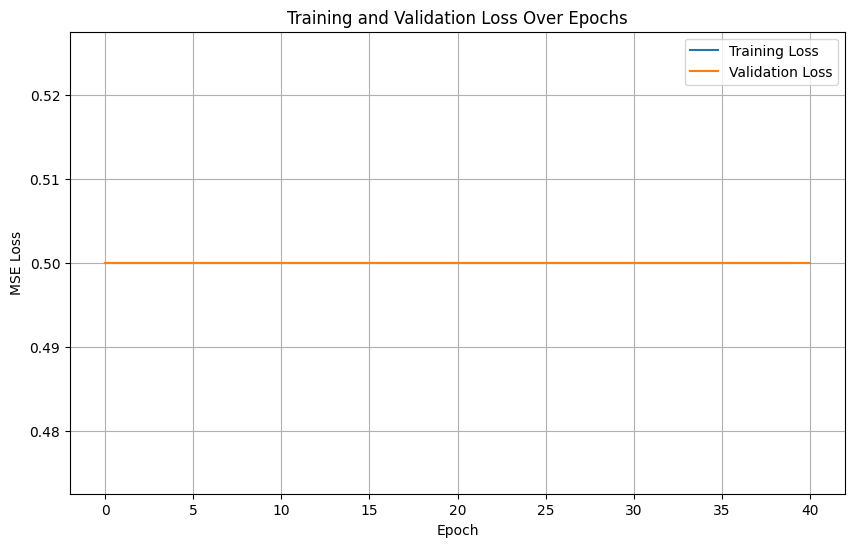

In [19]:
#Generated by Gemini

# Extract training loss data
train_epochs = [item[0] for item in m.train_loss]
train_losses = [item[1] for item in m.train_loss]

# Extract validation loss data
val_epochs = [item[0] for item in m.val_loss]
val_losses = [item[1] for item in m.val_loss]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label='Training Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

##MNIST Basic Model

In [20]:
y_val.shape

(10000, 10)

In [21]:
y_train.shape

(60000, 10)

In [22]:
nreg_model = Model([Dense(3,784,512,512,activ="relu",f_activ="relu"),Dense(1,512,256,10,f_activ="softmax")])
nreg_model.train(150, x_train[:10000],y_train[:10000],x_val[:500],y_val[:500],val_run=5, l_rate=0.01, batch_size=128)

epoch: 0 	 loss: 2.4115801275705415
epoch: 5 	 loss: 0.5035024931483483
epoch: 10 	 loss: 0.3607324001920334
epoch: 15 	 loss: 0.3095525470862638
epoch: 20 	 loss: 0.2756531806362141
epoch: 25 	 loss: 0.25873849342632593
epoch: 30 	 loss: 0.23401538776257916
epoch: 35 	 loss: 0.22868266033119317
epoch: 40 	 loss: 0.21028203055247477
epoch: 45 	 loss: 0.20516298716892095
epoch: 50 	 loss: 0.20048472894320293
epoch: 55 	 loss: 0.19001138384948849
epoch: 60 	 loss: 0.18329084766425824
epoch: 65 	 loss: 0.1847284865559543
epoch: 70 	 loss: 0.17372791450749106
epoch: 75 	 loss: 0.16648595115810613
epoch: 80 	 loss: 0.16838484312065788
epoch: 85 	 loss: 0.16430424421167414
epoch: 90 	 loss: 0.16339858101525237
epoch: 95 	 loss: 0.16230090381226137
epoch: 100 	 loss: 0.1569482209699723


In [23]:
nreg_model(x_val[:5]).vals, y_val[:5]

(array([[6.93843804e-07, 1.04404934e-07, 1.01823017e-03, 1.38799532e-02,
         6.19933079e-09, 3.61188809e-06, 2.48894821e-11, 9.85083453e-01,
         1.14369559e-06, 1.28033315e-05],
        [2.13681139e-05, 1.32342108e-04, 9.96223474e-01, 1.28733444e-03,
         6.63573998e-10, 1.92849234e-04, 2.09680107e-03, 5.50093137e-09,
         4.58187500e-05, 6.01884165e-09],
        [1.01264515e-06, 9.94468709e-01, 1.64970795e-03, 6.97416477e-04,
         1.21478407e-04, 1.40992105e-04, 3.78213974e-04, 8.39224833e-04,
         1.68790265e-03, 1.53423450e-05],
        [9.99743415e-01, 2.71179051e-10, 1.75116747e-04, 1.43412509e-06,
         6.79246500e-10, 6.26747156e-06, 4.58900046e-05, 1.22268820e-05,
         7.17549131e-08, 1.55771116e-05],
        [2.80501952e-06, 5.81317125e-07, 1.56061441e-04, 4.02441518e-06,
         9.72926931e-01, 5.14658759e-06, 5.86165626e-05, 7.62709524e-04,
         2.69329423e-05, 2.60561915e-02]]),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        

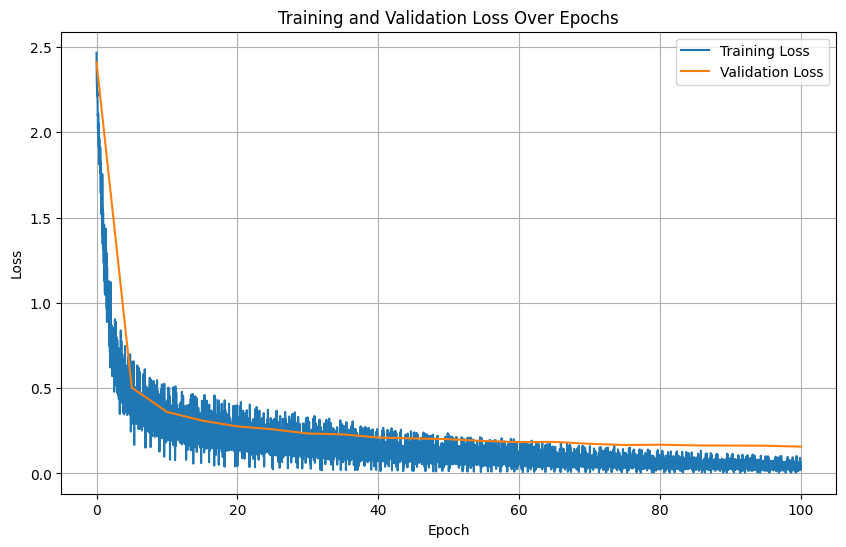

In [24]:
# Extract training loss data
train_epochs = [item[0] for item in nreg_model.train_loss]
train_losses = [item[1] for item in nreg_model.train_loss]

# Extract validation loss data
val_epochs = [item[0] for item in nreg_model.val_loss]
val_losses = [item[1] for item in nreg_model.val_loss]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label='Training Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

##MNIST Dropout Model

In [25]:
do_model = Model([Dense(3,784,512,512,activ="relu",f_activ="relu"),Dropout(512,0.4),Dense(1,512,256,10,f_activ="softmax")])
do_model.train(150, x_train[:10000],y_train[:10000],x_val[:500],y_val[:500],val_run=5, l_rate=0.01, batch_size=128)

epoch: 0 	 loss: 2.386414601669691
epoch: 5 	 loss: 0.513418070997204
epoch: 10 	 loss: 0.3632371644574911
epoch: 15 	 loss: 0.3109243239311801
epoch: 20 	 loss: 0.2811764438064669
epoch: 25 	 loss: 0.25657268557977086
epoch: 30 	 loss: 0.2372567557839863
epoch: 35 	 loss: 0.230339256975813
epoch: 40 	 loss: 0.21603702059279686
epoch: 45 	 loss: 0.2065994046400416
epoch: 50 	 loss: 0.20866955731233122
epoch: 55 	 loss: 0.1948247619768029
epoch: 60 	 loss: 0.18282584821596876
epoch: 65 	 loss: 0.18122590186467505
epoch: 70 	 loss: 0.17634819519724257
epoch: 75 	 loss: 0.17108186776459075
epoch: 80 	 loss: 0.16891470033929773
epoch: 85 	 loss: 0.16574098051096053
epoch: 90 	 loss: 0.16508414799889004
epoch: 95 	 loss: 0.16405775521603863
epoch: 100 	 loss: 0.1570979972614621


In [26]:
do_model(x_val[:5]).vals, y_val[:5]

(array([[1.67922575e-05, 2.07064197e-06, 3.54684024e-04, 3.49789555e-03,
         1.87865173e-07, 2.46126158e-06, 1.92423791e-08, 9.96101181e-01,
         2.96548077e-06, 2.17427314e-05],
        [1.18059624e-04, 1.37824766e-04, 9.92005132e-01, 4.97001576e-03,
         5.49769340e-08, 2.55714949e-04, 2.37790776e-03, 4.07548317e-07,
         1.34711708e-04, 1.70603466e-07],
        [1.97885940e-05, 9.95064995e-01, 1.93328231e-03, 3.99773341e-04,
         3.81193884e-04, 5.05320949e-05, 9.90100251e-05, 9.17502490e-04,
         1.06901662e-03, 6.49060800e-05],
        [9.99926839e-01, 3.18124796e-08, 2.63218291e-05, 3.43321420e-07,
         6.23270004e-09, 3.50875957e-06, 2.16863559e-05, 1.42589923e-05,
         6.54841958e-07, 6.34884481e-06],
        [1.04002073e-05, 2.91095990e-06, 2.06377176e-04, 7.31931548e-07,
         9.75391329e-01, 6.55087256e-06, 6.98155890e-05, 2.55921665e-04,
         1.36850150e-04, 2.39191120e-02]]),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        

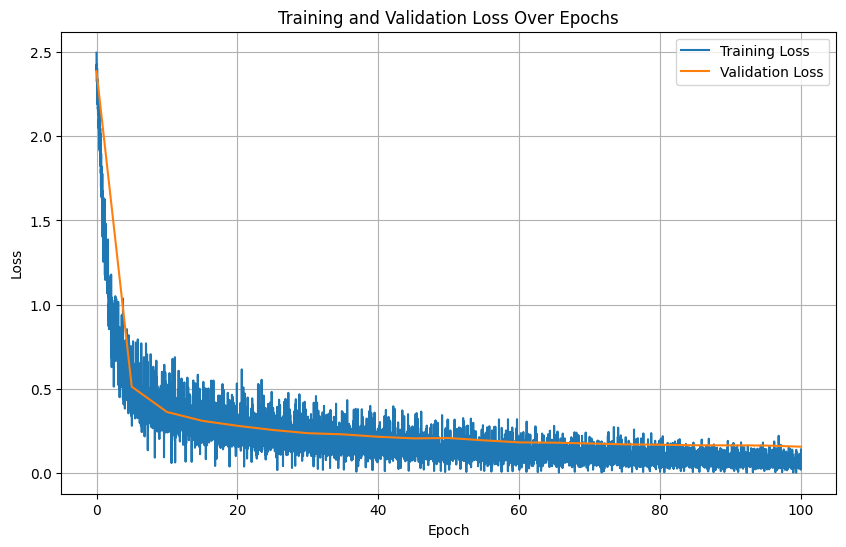

In [27]:
# Extract training loss data
train_epochs = [item[0] for item in do_model.train_loss]
train_losses = [item[1] for item in do_model.train_loss]

# Extract validation loss data
val_epochs = [item[0] for item in do_model.val_loss]
val_losses = [item[1] for item in do_model.val_loss]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label='Training Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

##MNIST L2 Norm Model

In [28]:
l2_model = Model([Dense(3,784,512,512,activ="relu",f_activ="relu"),Dense(1,512,256,10,f_activ="softmax")],pen_fn=l2_reg)
l2_model.train(150, x_train[:10000],y_train[:10000],x_val[:500],y_val[:500],val_run=5, l_rate=0.01, _lambda=0.001, batch_size=128)

epoch: 0 	 loss: 2.362232807520443
epoch: 5 	 loss: 0.4934775672716778
epoch: 10 	 loss: 0.3619238673673197
epoch: 15 	 loss: 0.3110346422756587
epoch: 20 	 loss: 0.2769327971247239
epoch: 25 	 loss: 0.2622214290606419
epoch: 30 	 loss: 0.24909153079909777
epoch: 35 	 loss: 0.23556561786819927
epoch: 40 	 loss: 0.2332059030591176
epoch: 45 	 loss: 0.21966785499776825
epoch: 50 	 loss: 0.2115799155776308
epoch: 55 	 loss: 0.20372762729632035
epoch: 60 	 loss: 0.2033081626745958
epoch: 65 	 loss: 0.19593842843297976
epoch: 70 	 loss: 0.1934002700476359
epoch: 75 	 loss: 0.19365587498315592
epoch: 80 	 loss: 0.18426427323567665
epoch: 85 	 loss: 0.1806490143318857
epoch: 90 	 loss: 0.18165597729313102
epoch: 95 	 loss: 0.18142993446687242
epoch: 100 	 loss: 0.17307423276282138


In [29]:
l2_model(x_val[:5]).vals, y_val[:5]

(array([[2.94340950e-05, 3.49848167e-06, 6.91633710e-04, 6.00865760e-03,
         2.68985006e-07, 2.02760983e-05, 1.19884413e-08, 9.92973202e-01,
         1.14683187e-05, 2.61548302e-04],
        [1.81992636e-03, 1.99551215e-04, 9.75864848e-01, 3.91980675e-03,
         1.77946829e-08, 5.37797170e-04, 1.68267726e-02, 4.92120689e-07,
         8.30396972e-04, 3.91059055e-07],
        [3.29783452e-05, 9.89421824e-01, 2.99589166e-03, 1.94809227e-03,
         6.21830181e-04, 6.55762800e-04, 7.97354782e-04, 1.63466709e-03,
         1.68580495e-03, 2.05794201e-04],
        [9.99759738e-01, 1.95240034e-09, 1.45038707e-04, 5.15815219e-07,
         9.91050622e-10, 1.12422794e-05, 2.85965843e-05, 3.16239657e-05,
         4.20438402e-07, 2.28213745e-05],
        [2.05865175e-05, 1.49573415e-06, 4.07921413e-04, 2.70291073e-06,
         9.81253054e-01, 9.49259318e-06, 1.10774557e-04, 9.92246671e-04,
         1.70065110e-04, 1.70316606e-02]]),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        

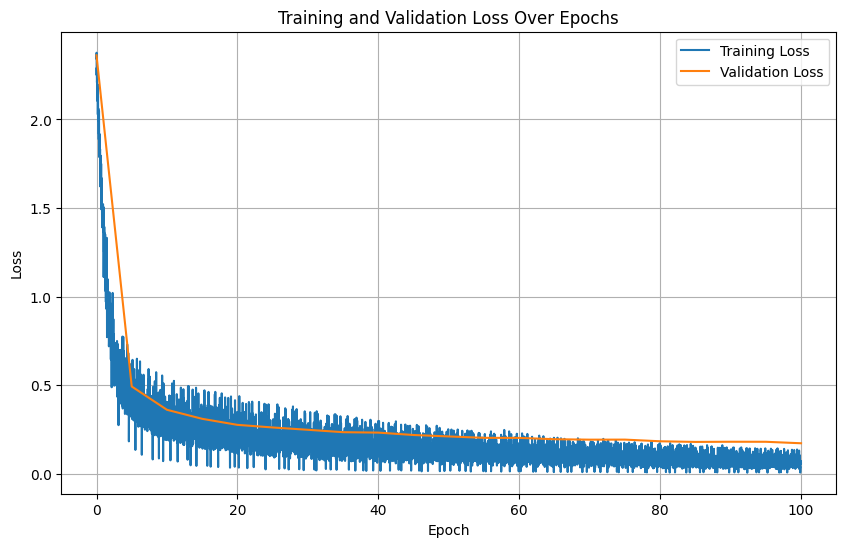

In [30]:
# Extract training loss data
train_epochs = [item[0] for item in l2_model.train_loss]
train_losses = [item[1] for item in l2_model.train_loss]

# Extract validation loss data
val_epochs = [item[0] for item in l2_model.val_loss]
val_losses = [item[1] for item in l2_model.val_loss]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label='Training Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

##MINST L2 & Dropout Model

In [31]:
l2do_model = Model([Dense(3,784,512,512,activ="relu",f_activ="relu"),Dropout(512,0.4),Dense(1,512,256,10,f_activ="softmax")],pen_fn=l2_reg)
l2do_model.train(150, x_train[:10000],y_train[:10000],x_val[:500],y_val[:500],val_run=5, l_rate=0.01, _lambda=0.001, batch_size=128)

epoch: 0 	 loss: 2.3729961112651363
epoch: 5 	 loss: 0.5150661678239332
epoch: 10 	 loss: 0.3622804675316688
epoch: 15 	 loss: 0.30834125967176673
epoch: 20 	 loss: 0.27928498476862673
epoch: 25 	 loss: 0.26442377184365784
epoch: 30 	 loss: 0.24640225308264035
epoch: 35 	 loss: 0.23006184059433007
epoch: 40 	 loss: 0.21948127818537813
epoch: 45 	 loss: 0.20944305064000515
epoch: 50 	 loss: 0.20750399293022165
epoch: 55 	 loss: 0.19981770638157503
epoch: 60 	 loss: 0.1913952078627188
epoch: 65 	 loss: 0.18759088740127358
epoch: 70 	 loss: 0.1826093028259916
epoch: 75 	 loss: 0.1818416154814737
epoch: 80 	 loss: 0.1736223898782175
epoch: 85 	 loss: 0.17290276982069488
epoch: 90 	 loss: 0.17253404895732502
epoch: 95 	 loss: 0.1656038282162981
epoch: 100 	 loss: 0.16532091623615205


In [32]:
l2do_model(x_val[:5]).vals, y_val[:5]

(array([[2.30525964e-05, 1.64636664e-05, 1.79354849e-04, 2.49761961e-03,
         5.83361468e-07, 2.81828351e-05, 3.42121180e-08, 9.97076056e-01,
         5.09278589e-06, 1.73560158e-04],
        [2.12918575e-03, 7.11962744e-04, 9.76715779e-01, 2.43344595e-03,
         1.98214805e-06, 5.60001210e-04, 1.65544440e-02, 3.96846065e-06,
         8.85762107e-04, 3.46841165e-06],
        [2.78551266e-05, 9.85845645e-01, 3.40855475e-03, 1.37026862e-03,
         1.45051571e-03, 8.58836632e-04, 1.03296901e-03, 3.57087961e-03,
         2.21771601e-03, 2.16759465e-04],
        [9.99323355e-01, 3.74355744e-07, 4.18820320e-04, 1.79976712e-05,
         4.43647045e-08, 3.46527546e-05, 1.26415718e-04, 3.99996403e-05,
         2.63883903e-06, 3.57015162e-05],
        [1.88336606e-05, 4.96959839e-05, 5.32707413e-04, 1.33218967e-05,
         9.75932063e-01, 8.49888957e-06, 2.48225386e-04, 1.27070218e-03,
         2.32308225e-04, 2.16936438e-02]]),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        

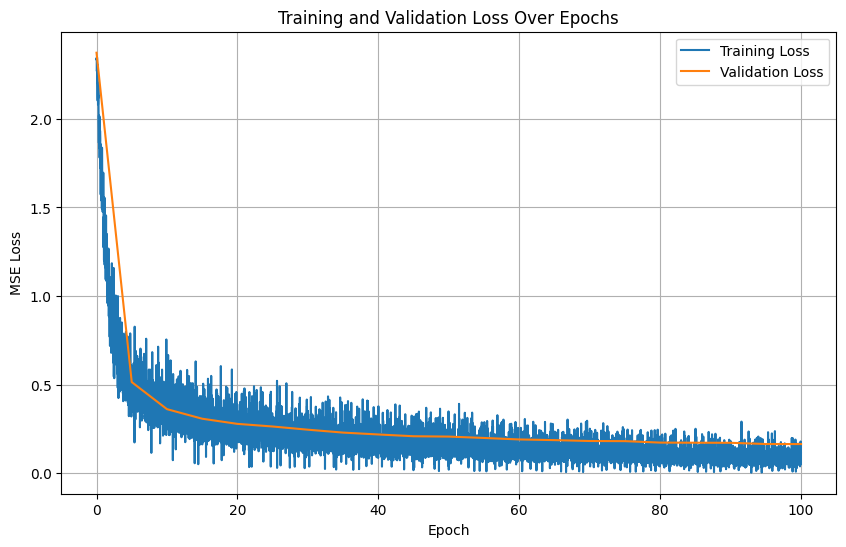

In [33]:
# Extract training loss data
train_epochs = [item[0] for item in l2do_model.train_loss]
train_losses = [item[1] for item in l2do_model.train_loss]

# Extract validation loss data
val_epochs = [item[0] for item in l2do_model.val_loss]
val_losses = [item[1] for item in l2do_model.val_loss]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label='Training Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

##Model Comparison

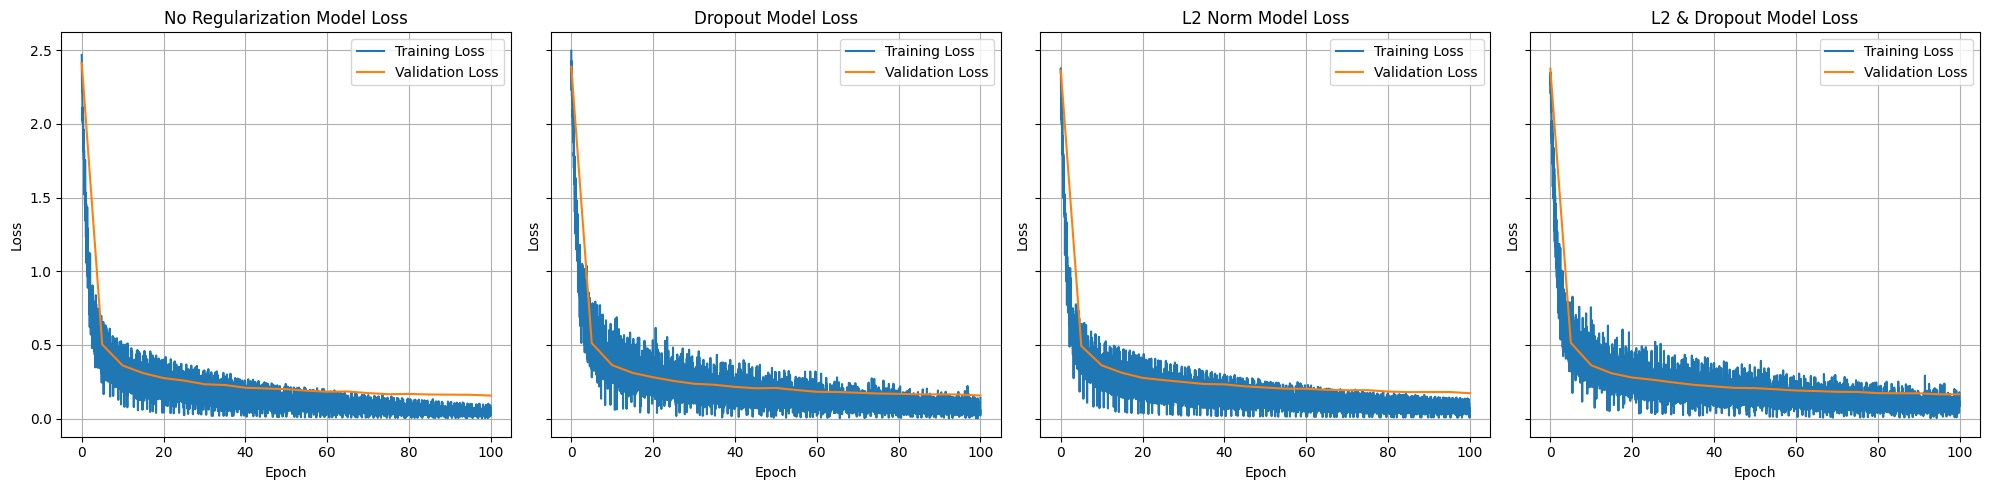

In [43]:
import matplotlib.pyplot as plt

# List of models and their display names
models_to_plot = {
    "No Regularization Model": nreg_model,
    "Dropout Model": do_model,
    "L2 Norm Model": l2_model,
    "L2 & Dropout Model": l2do_model
}

# Create a figure with subplots
num_models = len(models_to_plot)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), sharey=True)

if num_models == 1: # Handle case of single subplot
    axes = [axes]

for ax, (model_name, model_obj) in zip(axes, models_to_plot.items()):
    # Extract training loss data
    train_epochs = [item[0] for item in model_obj.train_loss]
    train_losses = [item[1] for item in model_obj.train_loss]

    # Extract validation loss data
    val_epochs = [item[0] for item in model_obj.val_loss]
    val_losses = [item[1] for item in model_obj.val_loss]

    # Plot on the current subplot
    ax.plot(train_epochs, train_losses, label='Training Loss')
    ax.plot(val_epochs, val_losses, label='Validation Loss')

    # Add labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{model_name} Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

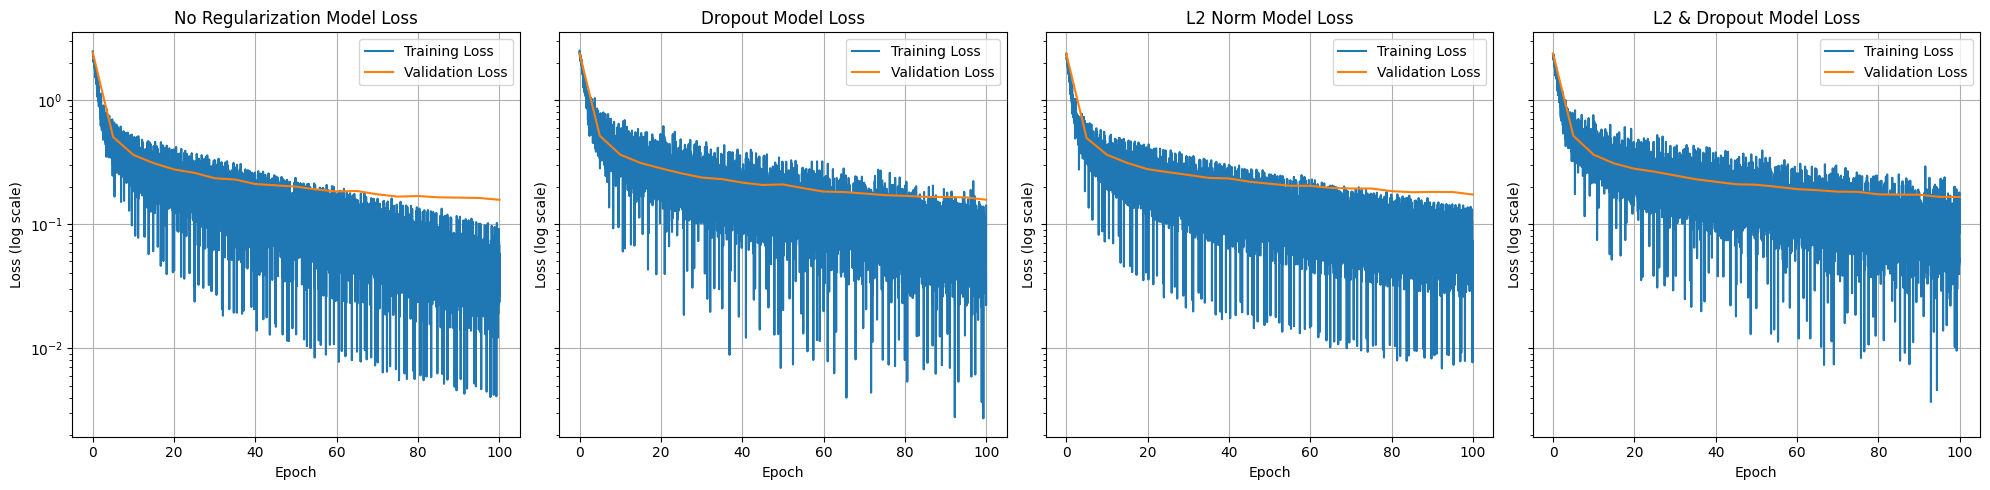

In [46]:
# Create a figure with subplots
num_models = len(models_to_plot)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), sharey=True)

if num_models == 1: # Handle case of single subplot
    axes = [axes]

for ax, (model_name, model_obj) in zip(axes, models_to_plot.items()):
    # Extract training loss data
    train_epochs = [item[0] for item in model_obj.train_loss]
    train_losses = [item[1] for item in model_obj.train_loss]

    # Extract validation loss data
    val_epochs = [item[0] for item in model_obj.val_loss]
    val_losses = [item[1] for item in model_obj.val_loss]

    # Plot on the current subplot
    ax.plot(train_epochs, train_losses, label='Training Loss')
    ax.plot(val_epochs, val_losses, label='Validation Loss')

    # Add labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (log scale)')
    ax.set_title(f'{model_name} Loss')
    ax.legend()
    ax.grid(True)

plt.yscale('log')
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

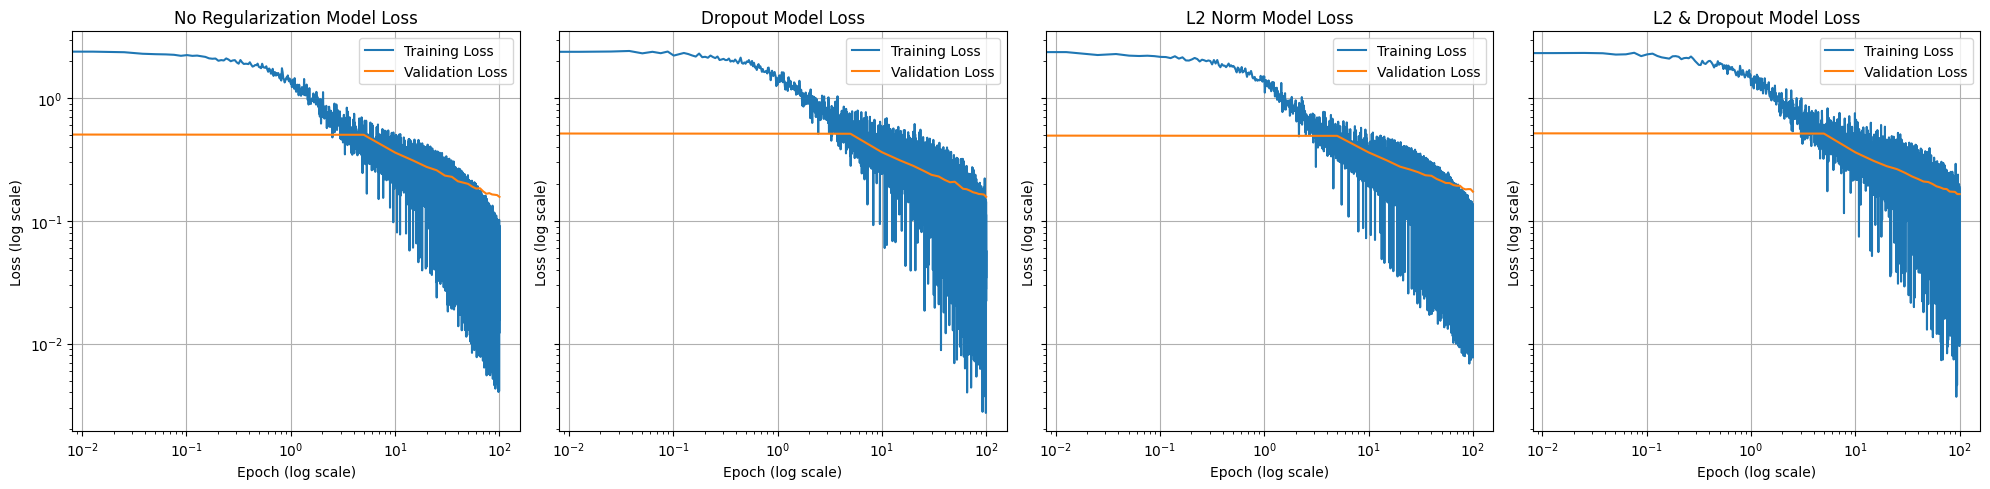

In [47]:
# Create a figure with subplots
num_models = len(models_to_plot)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), sharey=True)

if num_models == 1: # Handle case of single subplot
    axes = [axes]

for ax, (model_name, model_obj) in zip(axes, models_to_plot.items()):
    # Extract training loss data
    train_epochs = [item[0] for item in model_obj.train_loss]
    train_losses = [item[1] for item in model_obj.train_loss]

    # Extract validation loss data
    val_epochs = [item[0] for item in model_obj.val_loss]
    val_losses = [item[1] for item in model_obj.val_loss]

    # Plot on the current subplot
    ax.plot(train_epochs, train_losses, label='Training Loss')
    ax.plot(val_epochs, val_losses, label='Validation Loss')

    # Add labels and title
    ax.set_xlabel('Epoch (log scale)')
    ax.set_ylabel('Loss (log scale)')
    ax.set_title(f'{model_name} Loss')
    ax.legend()
    ax.grid(True)
    ax.set_yscale('log') # Apply log scale to y-axis for current subplot
    ax.set_xscale('log') # Apply log scale to x-axis for current subplot

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

##Digital Interface
Brought to you by Google Gemini

In [35]:
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from google.colab import output

# This global variable will store the 28x28 drawn image data from JS
drawn_image_for_model = None

# Function to be called from JavaScript after the user draws and clicks 'Predict'
def process_and_predict_digit(pixels_flat, model_name):
    global drawn_image_for_model

    # Convert JS array (flattened) to numpy array and reshape to 28x28
    drawn_image_for_model = np.array(pixels_flat).reshape(28, 28)

    # Display the drawn image (processed for model input)
    plt.figure(figsize=(4, 4))
    plt.imshow(drawn_image_for_model, cmap='gray')
    plt.title("Your Drawn Digit (Processed)")
    plt.axis('off')
    plt.show()

    # Preprocess the drawn image for the model (already normalized 0-1)
    input_for_model = Values(drawn_image_for_model.reshape(1, 784), grads=False)

    # Select the model based on the provided model_name
    selected_model = None
    if model_name == 'nreg_model':
        selected_model = nreg_model
    elif model_name == 'do_model':
        selected_model = do_model
    elif model_name == 'l2_model':
        selected_model = l2_model
    elif model_name == 'l2do_model':
        selected_model = l2do_model
    else:
        print(f"Error: Unknown model name '{model_name}'. Using 'nreg_model' as default.")
        selected_model = nreg_model

    # Run through the selected model
    prediction_output = selected_model(input_for_model)

    # Display the prediction
    predicted_probabilities = prediction_output.vals
    predicted_digit = np.argmax(predicted_probabilities)

    print(f"\nModel ({model_name}) Predicted Probabilities: {predicted_probabilities}")
    print(f"Model ({model_name}) Predicted Digit: {predicted_digit}")

# Register the Python function to be callable from JavaScript
output.register_callback('predict_digit_callback', process_and_predict_digit)

# HTML and JavaScript for the interactive drawing canvas
html_code = HTML('''
    <style>
        .drawing-canvas {
            border: 2px solid #555;
            background-color: #000;
            cursor: crosshair;
        }
        .draw-container {
            margin-bottom: 10px;
            border: 1px solid #ddd;
            padding: 10px;
            border-radius: 8px;
            background-color: #f9f9f9;
        }
        .draw-button,
        .clear-button {
            background-color: #4CAF50; /* Green */
            border: none;
            color: white;
            padding: 10px 20px;
            text-align: center;
            text-decoration: none;
            display: inline-block;
            font-size: 16px;
            margin: 4px 2px;
            cursor: pointer;
            border-radius: 5px;
        }
        .clear-button {
            background-color: #f44336; /* Red */
        }
        .model-selector-container {
            margin-bottom: 10px;
        }
    </style>
    <div class="draw-container">
        <h3>Draw a digit below:</h3>
        <div class="model-selector-container">
            <label for="modelSelector">Select Model:</label>
            <select id="modelSelector">
                <option value="nreg_model">No Regularization Model</option>
                <option value="do_model">Dropout Model</option>
                <option value="l2_model">L2 Model</option>
                <option value="l2do_model">L2 & Dropout Model</option>
            </select>
        </div>
        <canvas id="drawingCanvas" width="280" height="280" class="drawing-canvas"></canvas><br/>
        <button class="draw-button" onclick="sendCanvasData()">Predict Drawn Digit</button>
        <button class="clear-button" onclick="clearCanvas()">Clear Canvas</button>
    </div>

    <script>
        var canvas = document.getElementById('drawingCanvas');
        var ctx = canvas.getContext('2d');
        var isDrawing = false;
        var lastX = 0;
        var lastY = 0;

        // Set drawing properties
        ctx.lineWidth = 20; // Thicker line for digit drawing
        ctx.lineCap = 'round';
        ctx.strokeStyle = '#FFFFFF'; // White drawing on black background
        ctx.fillStyle = '#000000'; // Set canvas background to black initially
        ctx.fillRect(0, 0, canvas.width, canvas.height); // Fill canvas with black

        // Event Listeners for drawing
        canvas.addEventListener('mousedown', (e) => {
            isDrawing = true;
            [lastX, lastY] = [e.offsetX, e.offsetY];
        });
        canvas.addEventListener('mousemove', draw);
        canvas.addEventListener('mouseup', () => isDrawing = false);
        canvas.addEventListener('mouseout', () => isDrawing = false);

        function draw(e) {
            if (!isDrawing) return;
            ctx.beginPath();
            ctx.moveTo(lastX, lastY);
            ctx.lineTo(e.offsetX, e.offsetY);
            ctx.stroke();
            [lastX, lastY] = [e.offsetX, e.offsetY];
        }

        function clearCanvas() {
            ctx.fillRect(0, 0, canvas.width, canvas.height);
        }

        function sendCanvasData() {
            var imageData = ctx.getImageData(0, 0, canvas.width, canvas.height);
            var pixels = [];
            var downsample_factor = 10; // 280x280 canvas scaled down to 28x28

            for (let y = 0; y < 28; y++) {
                for (let x = 0; x < 28; x++) {
                    let sum_brightness = 0;
                    let count = 0;
                    // Average pixel values in a 10x10 block
                    for (let sy = 0; sy < downsample_factor; sy++) {
                        for (let sx = 0; sx < downsample_factor; sx++) {
                            let pixel_index = ((y * downsample_factor + sy) * canvas.width + (x * downsample_factor + sx)) * 4;
                            // We only need one channel (e.g., Red) for grayscale brightness
                            sum_brightness += imageData.data[pixel_index];
                            count++;
                        }
                    }
                    // Normalize averaged brightness to 0-1 range
                    pixels.push((sum_brightness / count) / 255.0);
                }
            }

            // Get selected model name from the dropdown
            var modelSelector = document.getElementById('modelSelector');
            var selectedModelName = modelSelector.value;

            // Call the Python function with the processed pixel data and selected model name
            google.colab.kernel.invokeFunction('predict_digit_callback', [pixels, selectedModelName], {});
        }
    </script>
''')

display(html_code)